# Cancer Detection

The problem is whether deep learning using a convolutional neural network can be used to detect cancer in histopathologic images. 

In [277]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

In [119]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
SAMPLE_SIZE = 40000

In [58]:
BASE_DIR = os.getcwd()
os.listdir(os.path.join(BASE_DIR, 'input'))

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

## Dataset Information

How many train/test images?

In [59]:
num_train = len(os.listdir(os.path.join(BASE_DIR, 'input\\train')))
num_test = len(os.listdir(os.path.join(BASE_DIR, 'input\\test')))
print(f"Train images: {num_train}")
print(f"Test images: {num_test}")

Train images: 220026
Test images: 57458


Import labels into a dataframe

In [66]:
df = pd.read_csv(os.path.join(BASE_DIR, 'input\\train_labels.csv'))
df.head

<bound method NDFrame.head of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>

Class distribution

<BarContainer object of 2 artists>

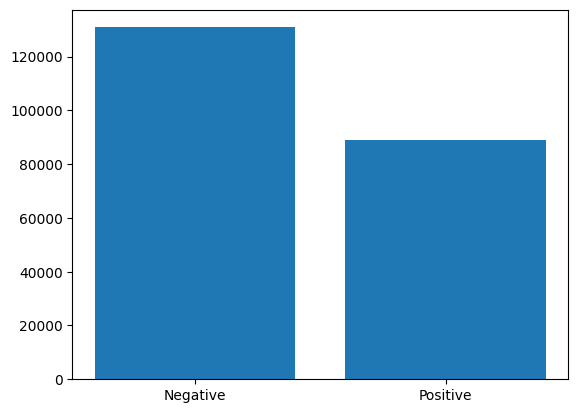

In [61]:
df['label'].value_counts()
plt.bar(["Negative", "Positive"], height=df['label'].value_counts())

Rather than use the whole dataset, let's sample 40,000 of each label and then create balanced train and test sets

In [120]:
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state=123)
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state=123)

sampled_df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
sampled_df = shuffle(sampled_df)
sampled_df['label'].value_counts()

# stratify to create balanced set
df_train, df_val = train_test_split(sampled_df, test_size=0.20, random_state=123, stratify=sampled_df['label'])

print(df_train.shape)
print(df_val.shape)
print(df_train['label'].value_counts())

(64000, 2)
(16000, 2)
1    32000
0    32000
Name: label, dtype: int64


Put images of the sampled IDs into a folder structure for the generator to use later

In [121]:
for idx, row in df_train.iterrows():
    fname = row['id'] + '.tif'
    label = "no_tumor" if row['label'] == 0 else "has_tumor"
    
    src = os.path.join(BASE_DIR, 'input//train', fname)
    dest = os.path.join(BASE_DIR, 'sampled//train', label, fname)
    
    shutil.copyfile(src, dest)

for idx, row in df_val.iterrows():
    fname = row['id'] + '.tif'
    label = "no_tumor" if row['label'] == 0 else "has_tumor"
    
    src = os.path.join(BASE_DIR, 'input//train', fname)
    dest = os.path.join(BASE_DIR, 'sampled//valid', label, fname)
    
    shutil.copyfile(src, dest)

In [302]:
train_path = os.path.join(BASE_DIR, 'sampled//train')
valid_path = os.path.join(BASE_DIR, 'sampled//valid')
test_path = os.path.join(BASE_DIR, 'input//competition')

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)



In [317]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

competition_gen = datagen.flow_from_directory(test_path,
                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = 1,
                                              class_mode=None,
                                              shuffle=False
                                             )
test_gen.class_indices

Found 64000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 57458 images belonging to 1 classes.


{'has_tumor': 0, 'no_tumor': 1}

# Modeling

## Base Model
Let's train a base model. Parameters are taken from https://www.tensorflow.org/tutorials/load_data/images with the addition of softmax in the final layer. Let's save the best epoch and use an adaptive learning rate. 

In [235]:
results = pd.DataFrame(columns=('model', 'loss', 'accuracy'))
results

,model,loss,accuracy


In [170]:
num_classes = 2

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (96, 96, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 3200)            

In [171]:
model1.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history1 = model1.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
2000/2000 [==============================] - 34s 16ms/step - loss: 0.4912 - accuracy: 0.7695 - val_loss: 0.4604 - val_accuracy: 0.7907

Epoch 00001: val_accuracy improved from -inf to 0.79069, saving model to model1.h5
Epoch 2/15
2000/2000 [==============================] - 31s 15ms/step - loss: 0.4582 - accuracy: 0.7880 - val_loss: 0.4450 - val_accuracy: 0.8005

Epoch 00002: val_accuracy improved from 0.79069 to 0.80050, saving model to model1.h5
Epoch 3/15
2000/2000 [==============================] - 29s 14ms/step - loss: 0.4341 - accuracy: 0.8007 - val_loss: 0.4176 - val_accuracy: 0.8146

Epoch 00003: val_accuracy improved from 0.80050 to 0.81456, saving model to model1.h5
Epoch 4/15
2000/2000 [==============================] - 29s 14ms/step - loss: 0.4162 - accuracy: 0.8130 - val_loss: 0.4071 - val_accuracy: 0.8210

Epoch 00004: val_accuracy improved from 0.81456 to 0.82100, saving model to model1.h5
Epoch 5/15
2000/2000 [==============================] - 29s 15ms/step -

In [218]:
model1.load_weights('model1.h5')

loss1, accuracy1 = model1.evaluate(test_gen)

print(f"Test loss: {loss1:.3f}")
print(f"Test accuracy: {accuracy1:.3f}")


16000/16000 [==============================] - 23s 1ms/step - loss: 0.3192 - accuracy: 0.8670
Test loss: 0.319
Test accuracy: 0.867


In [242]:
results = pd.DataFrame(columns=('model', 'loss', 'accuracy'))
results.loc[0] = ['base', loss1, accuracy1]
results

,model,loss,accuracy
0,base,0.319171,0.867


The best epoch from the base model had a test accuracy of 0.87.

Let's try adding regularization (dropout), which prevents overfitting.

## Regularization Layers

In [173]:
dropout_conv = 0.3
dropout_dense = 0.3

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (96, 96, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model2.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 20, 20, 32)      

In [174]:
model2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history2 = model2.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
2000/2000 [==============================] - 31s 15ms/step - loss: 0.5257 - accuracy: 0.7387 - val_loss: 0.5509 - val_accuracy: 0.7321

Epoch 00001: val_accuracy improved from -inf to 0.73212, saving model to model2.h5
Epoch 2/15
2000/2000 [==============================] - 30s 15ms/step - loss: 0.4736 - accuracy: 0.7836 - val_loss: 0.5073 - val_accuracy: 0.7641

Epoch 00002: val_accuracy improved from 0.73212 to 0.76406, saving model to model2.h5
Epoch 3/15
2000/2000 [==============================] - 29s 14ms/step - loss: 0.4545 - accuracy: 0.7932 - val_loss: 0.4830 - val_accuracy: 0.7738

Epoch 00003: val_accuracy improved from 0.76406 to 0.77381, saving model to model2.h5
Epoch 4/15
2000/2000 [==============================] - 30s 15ms/step - loss: 0.4377 - accuracy: 0.8039 - val_loss: 0.4829 - val_accuracy: 0.7756

Epoch 00004: val_accuracy improved from 0.77381 to 0.77562, saving model to model2.h5
Epoch 5/15
2000/2000 [==============================] - 30s 15ms/step -

In [247]:
model2.load_weights('model2.h5')

loss, accuracy = model2.evaluate(test_gen)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")


16000/16000 [==============================] - 21s 1ms/step - loss: 0.4747 - accuracy: 0.7886
Test loss: 0.475
Test accuracy: 0.789


In [248]:
results.loc[1] = ['dropout', loss, accuracy]

Adding regularization lowered the accuracy to 0.79, suggesting that it was overfitting before.

## Increasing Filter Sizes

Let's try having increasing convolutional filters (32, 64 & 128). 

In [177]:
dropout_conv = 0.3
dropout_dense = 0.3

model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (96, 96, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model3.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 20, 20, 128)     

In [178]:
model3.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history3 = model3.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
2000/2000 [==============================] - 31s 15ms/step - loss: 0.5273 - accuracy: 0.7398 - val_loss: 0.5117 - val_accuracy: 0.7864

Epoch 00001: val_accuracy improved from -inf to 0.78637, saving model to model3.h5
Epoch 2/15
2000/2000 [==============================] - 29s 15ms/step - loss: 0.4681 - accuracy: 0.7859 - val_loss: 0.4810 - val_accuracy: 0.7843

Epoch 00002: val_accuracy did not improve from 0.78637
Epoch 3/15
2000/2000 [==============================] - 29s 14ms/step - loss: 0.4492 - accuracy: 0.7968 - val_loss: 0.4531 - val_accuracy: 0.8117

Epoch 00003: val_accuracy improved from 0.78637 to 0.81169, saving model to model3.h5
Epoch 4/15
2000/2000 [==============================] - 29s 15ms/step - loss: 0.4274 - accuracy: 0.8082 - val_loss: 0.4493 - val_accuracy: 0.7989

Epoch 00004: val_accuracy did not improve from 0.81169
Epoch 5/15
2000/2000 [==============================] - 29s 14ms/step - loss: 0.4049 - accuracy: 0.8188 - val_loss: 0.4453 - val_accu

In [254]:
model3.load_weights('model3.h5')

loss, accuracy = model3.evaluate(test_gen)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")

16000/16000 [==============================] - 19s 1ms/step - loss: 0.3859 - accuracy: 0.8348
Test loss: 0.386
Test accuracy: 0.835


In [255]:
results.loc[2] = ['dropout+inc_filters', loss, accuracy]

Adding increasing filter sizes increased the accuracy without it overfitting

## Larger Dense Layer

Let's try doubling the size of the dense layer to 256

In [180]:
dropout_conv = 0.3
dropout_dense = 0.3

model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (96, 96, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model4.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 20, 20, 128)     

In [181]:
model4.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model4.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history4 = model4.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
2000/2000 [==============================] - 30s 15ms/step - loss: 0.5129 - accuracy: 0.7520 - val_loss: 0.5197 - val_accuracy: 0.7594

Epoch 00001: val_accuracy improved from -inf to 0.75937, saving model to model4.h5
Epoch 2/15
2000/2000 [==============================] - 30s 15ms/step - loss: 0.4628 - accuracy: 0.7870 - val_loss: 0.4827 - val_accuracy: 0.7793

Epoch 00002: val_accuracy improved from 0.75937 to 0.77925, saving model to model4.h5
Epoch 3/15
2000/2000 [==============================] - 29s 14ms/step - loss: 0.4380 - accuracy: 0.8015 - val_loss: 0.4614 - val_accuracy: 0.7934

Epoch 00003: val_accuracy improved from 0.77925 to 0.79344, saving model to model4.h5
Epoch 4/15
2000/2000 [==============================] - 29s 15ms/step - loss: 0.4157 - accuracy: 0.8140 - val_loss: 0.4971 - val_accuracy: 0.7473

Epoch 00004: val_accuracy did not improve from 0.79344
Epoch 5/15
2000/2000 [==============================] - 30s 15ms/step - loss: 0.3926 - accuracy: 0.826

In [256]:
model4.load_weights('model4.h5')

loss, accuracy = model4.evaluate(test_gen)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")

16000/16000 [==============================] - 20s 1ms/step - loss: 0.4614 - accuracy: 0.7934
Test loss: 0.461
Test accuracy: 0.793


In [257]:
results.loc[3] = ['dropout+inc_filters+larger_dense', loss, accuracy]

A larger dense layer reduced the accuracy to 0.79, suggesting that a more complex architecture isn't necessarily better. 

# Duplicating Convolutions

Let's try repeating the convolutional layers

In [183]:
dropout_conv = 0.3
dropout_dense = 0.3

model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (96, 96, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model5.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 41, 41, 64)      

In [184]:
model5.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model5.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history5 = model5.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15
2000/2000 [==============================] - 36s 18ms/step - loss: 0.4965 - accuracy: 0.7617 - val_loss: 0.4834 - val_accuracy: 0.7721

Epoch 00001: val_accuracy improved from -inf to 0.77206, saving model to model5.h5
Epoch 2/15
2000/2000 [==============================] - 35s 18ms/step - loss: 0.4374 - accuracy: 0.8042 - val_loss: 0.4954 - val_accuracy: 0.7918

Epoch 00002: val_accuracy improved from 0.77206 to 0.79175, saving model to model5.h5
Epoch 3/15
2000/2000 [==============================] - 35s 17ms/step - loss: 0.3903 - accuracy: 0.8275 - val_loss: 0.4573 - val_accuracy: 0.7922

Epoch 00003: val_accuracy improved from 0.79175 to 0.79219, saving model to model5.h5
Epoch 4/15
2000/2000 [==============================] - 35s 17ms/step - loss: 0.3559 - accuracy: 0.8455 - val_loss: 0.3900 - val_accuracy: 0.8326

Epoch 00004: val_accuracy improved from 0.79219 to 0.83256, saving model to model5.h5
Epoch 5/15
2000/2000 [==============================] - 35s 18ms/step -

In [258]:
model5.load_weights('model5.h5')

loss, accuracy = model5.evaluate(test_gen)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")

16000/16000 [==============================] - 24s 1ms/step - loss: 0.2400 - accuracy: 0.9051
Test loss: 0.240
Test accuracy: 0.905


In [259]:
results.loc[4] = ['dropout+inc_filters+repeated_convs', loss, accuracy]

In [267]:
# results.sort_index(inplace=True)
results

,model,loss,accuracy
0,base,0.319171,0.867000
1,dropout,0.474660,0.788625
2,dropout+inc_filters,0.385878,0.834813
3,dropout+inc_filters+larger_dense,0.461351,0.793437
4,dropout+inc_filters+repeated_convs,0.240045,0.905062


<AxesSubplot: xlabel='model'>

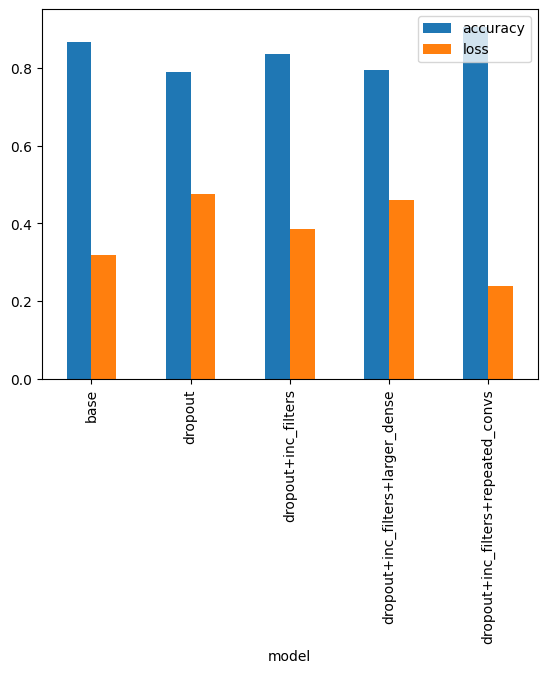

In [276]:
results.plot(x="model", y=["accuracy", "loss"], kind='bar')

# Hyperparmeter Tuning

Now that we have a solid architecture, let's use keras tuner to tune the hyperparameters. Let's tune the dropout percentage, the number of neurons in the densely connected layer and the learning rate. 

In [292]:
def model_builder(hp):
    # the hyperparameters to be tuned
    hp_dropout = hp.Choice('dropout', values=[0.2, 0.5])
    hp_units = hp.Choice('units', values=[64, 128, 256])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5])
    
    model = keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (96, 96, 3)))
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(dropout_conv))

    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(dropout_conv))
    
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Dropout(dropout_conv))
    
    model.add(tf.keras.layers.Flatten())

    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model


In [293]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner_callbacks_list = [stop_early]

# tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
tuner.search(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=15,
    callbacks=tuner_callbacks_list
)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


# print(f"""
# The optimal dropout_conv is {best_hps.get('dropout_conv')},
# The optimal dropout_dense is {best_hps.get('dropout_dense')},
# The optimal number of units in the last densely-connected layer is {best_hps.get('units')} and 
# the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)

Trial 18 Complete [00h 03m 47s]
val_accuracy: 0.8261874914169312

Best val_accuracy So Far: 0.8363749980926514
Total elapsed time: 00h 26m 29s
INFO:tensorflow:Oracle triggered exit


In [294]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.2
units: 128
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8363749980926514
Trial summary
Hyperparameters:
dropout: 0.5
units: 64
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8335000276565552
Trial summary
Hyperparameters:
dropout: 0.5
units: 64
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.8261874914169312
Trial summary
Hyperparameters:
dropout: 0.2
units: 64
learning_rate: 0.0001
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0007
Score: 0.8261250257492065
Trial summary
Hyperparameters:
dropout: 0.5
units: 64
learning_rate: 0.0001
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0005
Score: 0.8151249885559082
T

The best dropout was 0.2, the best number of densely connected neurons was 128 (which is what we began with) and the learning rate was 0.0001 (also what we began with)

Let's train the hypertuned model for 20 epochs

In [296]:
hypermodel = tuner.hypermodel.build(best_hps)

checkpoint = ModelCheckpoint("model_hyper.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

history_hypermodel = hypermodel.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=20,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/20
2000/2000 [==============================] - 36s 18ms/step - loss: 0.4897 - accuracy: 0.7614 - val_loss: 0.4936 - val_accuracy: 0.7701

Epoch 00001: val_accuracy improved from -inf to 0.77006, saving model to model_hyper.h5
Epoch 2/20
2000/2000 [==============================] - 36s 18ms/step - loss: 0.4205 - accuracy: 0.8125 - val_loss: 0.4431 - val_accuracy: 0.7900

Epoch 00002: val_accuracy improved from 0.77006 to 0.79000, saving model to model_hyper.h5
Epoch 3/20
2000/2000 [==============================] - 35s 18ms/step - loss: 0.3910 - accuracy: 0.8281 - val_loss: 0.4252 - val_accuracy: 0.8004

Epoch 00003: val_accuracy improved from 0.79000 to 0.80037, saving model to model_hyper.h5
Epoch 4/20
2000/2000 [==============================] - 35s 18ms/step - loss: 0.3643 - accuracy: 0.8408 - val_loss: 0.4761 - val_accuracy: 0.7979

Epoch 00004: val_accuracy did not improve from 0.80037
Epoch 5/20
2000/2000 [==============================] - 34s 17ms/step - loss: 0.3360 - 

In [297]:
hypermodel.load_weights('model_hyper.h5')

loss, accuracy = hypermodel.evaluate(test_gen)

print(f"Test loss: {loss:.3f}")
print(f"Test accuracy: {accuracy:.3f}")

16000/16000 [==============================] - 23s 1ms/step - loss: 0.3072 - accuracy: 0.8690
Test loss: 0.307
Test accuracy: 0.869


# Predicting on the Test Data

In [318]:
predictions = hypermodel.predict(competition_gen, steps = 57458, verbose=1)

57458/57458 [==============================] - 213s 4ms/step


In [320]:
df_preds = pd.DataFrame(predictions, columns=['has_tumor_tissue', 'no_tumor_tissue', ])
df_preds['file_names'] = competition_gen.filenames
df_preds.head()

,has_tumor_tissue,no_tumor_tissue,file_names
0,0.999956,0.000043,test\00006537328c33e284c973d7b39d340809f7271b.tif
1,0.999827,0.000173,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,0.996456,0.003544,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,0.951028,0.048972,test\000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,0.002378,0.997622,test\000270442cc15af719583a8172c87cd2bd9c7746.tif


In [321]:
def get_id(x):
    a = x.split('\\')
    b = a[1].split('.')
    return b[0]

df_preds['id'] = df_preds['file_names'].apply(get_id)
df_preds.head()

,has_tumor_tissue,no_tumor_tissue,file_names,id
0,0.999956,0.000043,test\00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,0.999827,0.000173,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.996456,0.003544,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.951028,0.048972,test\000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.002378,0.997622,test\000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [322]:
def tumor_label(x):
    present = 1 if x > 0.5 else 0
    return present

submission = pd.DataFrame({'id':df_preds['id'], 'label':df_preds['has_tumor_tissue'].apply(tumor_label)})
submission.head()
submission.to_csv('am_cancer_03.csv', index=False) 

# Conclusion

- Adding dropout prevented overfitting but didn't increase accuracy
- Adding increasing filter sizes for each group of layers increased accuracy a little
- Having more neurons in the densely connected layer didn't increase accuracy
- Repeating convolutonal layers increased accuracy a lot
- Hyperparameter tuning was performed, but a lot of the parameters didn't change
- Could run for longer, or look at all images in the dataset